# KNN e SVM

KNN ou K-Nearest Neighbors é um algoritmo de classificação supervisionado. A classificação é feita por uma votação majoritária dos vizinhos mais próximos do objeto a ser classificado.

SVM ou Support Vector Machine é um algoritmo de classificação supervisionado. A classificação é feita por um hiperplano que separa os dados em classes. O hiperplano é escolhido de forma que a margem entre as classes seja a maior possível.

# Recrutamento preditivo

A empresa de tecnologia HighTech busca contratar os melhores profissionais do mercado para fazer parte do time e gerar valor para a empresa. A HighTech vem investindo muito nos últimos anos no uso de ciência de dados no setor do RH para trazer ganhos no processo de seleção e recrutamento. O time de ciência de dados junto com o time de RH vem realizando juntos um projeto de recrutamento preditivo.

O recrutamento preditivo é uma técnica de People Analytics para encontrar os melhores candidatos para contratação da empresa, na prática, o recrutamento preditivo aumenta as chances do recrutador potencializar o processo de seleção. Por meio da coleta e análise de dados, é possível avaliar o perfil e o fit cultural dos profissionais para entender se existe uma boa aderência à vaga. 

**Problema de negócio:**

O objetivo da HighTech é identificar quais são os melhores indicadores para realizar o recrutamento de profissionais. 

**Base de dados**

Este conjunto de dados consiste em algumas características como: percentual de ensino médio e superior e especialização, experiência de trabalho e ofertas salariais para os profissionais colocados.

**Desafio**

Você como cientista de dados do time de dados da HighTech tem o desafio de criar um modelo preditivo de recrutamento para prever como e quais são as melhores variáveis que podem colocar um profissional bem qualificado na HighTech.

In [15]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

## Parte 1

In [5]:
df = pl.read_excel('data/recrutamento.xlsx')
df.sample(5)

sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
i64,str,f64,str,f64,str,str,f64,str,str,f64,str,f64,str,i64
56,"""M""",60.4,"""Central""",66.6,"""Others""","""Science""",65.0,"""Comm&Mgmt""","""No""",71.0,"""Mkt&HR""",52.71,"""Yes""",220000
53,"""F""",40.89,"""Others""",45.83,"""Others""","""Commerce""",53.0,"""Comm&Mgmt""","""No""",71.2,"""Mkt&HR""",65.49,"""No""",null
42,"""F""",74.0,"""Others""",63.16,"""Others""","""Commerce""",65.0,"""Comm&Mgmt""","""Yes""",65.0,"""Mkt&HR""",69.76,"""No""",null
130,"""M""",76.7,"""Central""",89.7,"""Others""","""Commerce""",66.0,"""Comm&Mgmt""","""Yes""",90.0,"""Mkt&Fin""",68.55,"""Yes""",250000
183,"""M""",52.0,"""Others""",65.0,"""Others""","""Arts""",57.0,"""Others""","""Yes""",75.0,"""Mkt&Fin""",59.81,"""No""",null


In [6]:
df.shape

(215, 15)

In [13]:
df.select('status').to_series().value_counts()

status,counts
str,u32
"""No""",67
"""Yes""",148


In [14]:
df.describe()

describe,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
str,f64,str,f64,str,f64,str,str,f64,str,str,f64,str,f64,str,f64
"""count""",215.0,"""215""",215.0,"""215""",215.0,"""215""","""215""",215.0,"""215""","""215""",215.0,"""215""",215.0,"""215""",215.0
"""null_count""",0.0,"""0""",0.0,"""0""",0.0,"""0""","""0""",0.0,"""0""","""0""",0.0,"""0""",0.0,"""0""",67.0
"""mean""",108.0,null,67.303395,null,66.333163,null,null,66.370186,null,null,72.100558,null,62.278186,null,288655.405405
"""std""",62.209324,null,10.827205,null,10.897509,null,null,7.358743,null,null,13.275956,null,5.833385,null,93457.45242
"""min""",1.0,"""F""",40.89,"""Central""",37.0,"""Central""","""Arts""",50.0,"""Comm&Mgmt""","""No""",50.0,"""Mkt&Fin""",51.21,"""No""",200000.0
"""25%""",54.0,null,60.4,null,60.8,null,null,61.0,null,null,60.0,null,57.9,null,240000.0
"""50%""",108.0,null,67.0,null,65.0,null,null,66.0,null,null,71.0,null,62.0,null,265000.0
"""75%""",162.0,null,76.0,null,73.0,null,null,72.0,null,null,84.0,null,66.28,null,300000.0
"""max""",215.0,"""M""",89.4,"""Others""",97.7,"""Others""","""Science""",91.0,"""Sci&Tech""","""Yes""",98.0,"""Mkt&HR""",77.89,"""Yes""",940000.0


Vamos verificar os dados nulos

<Axes: >

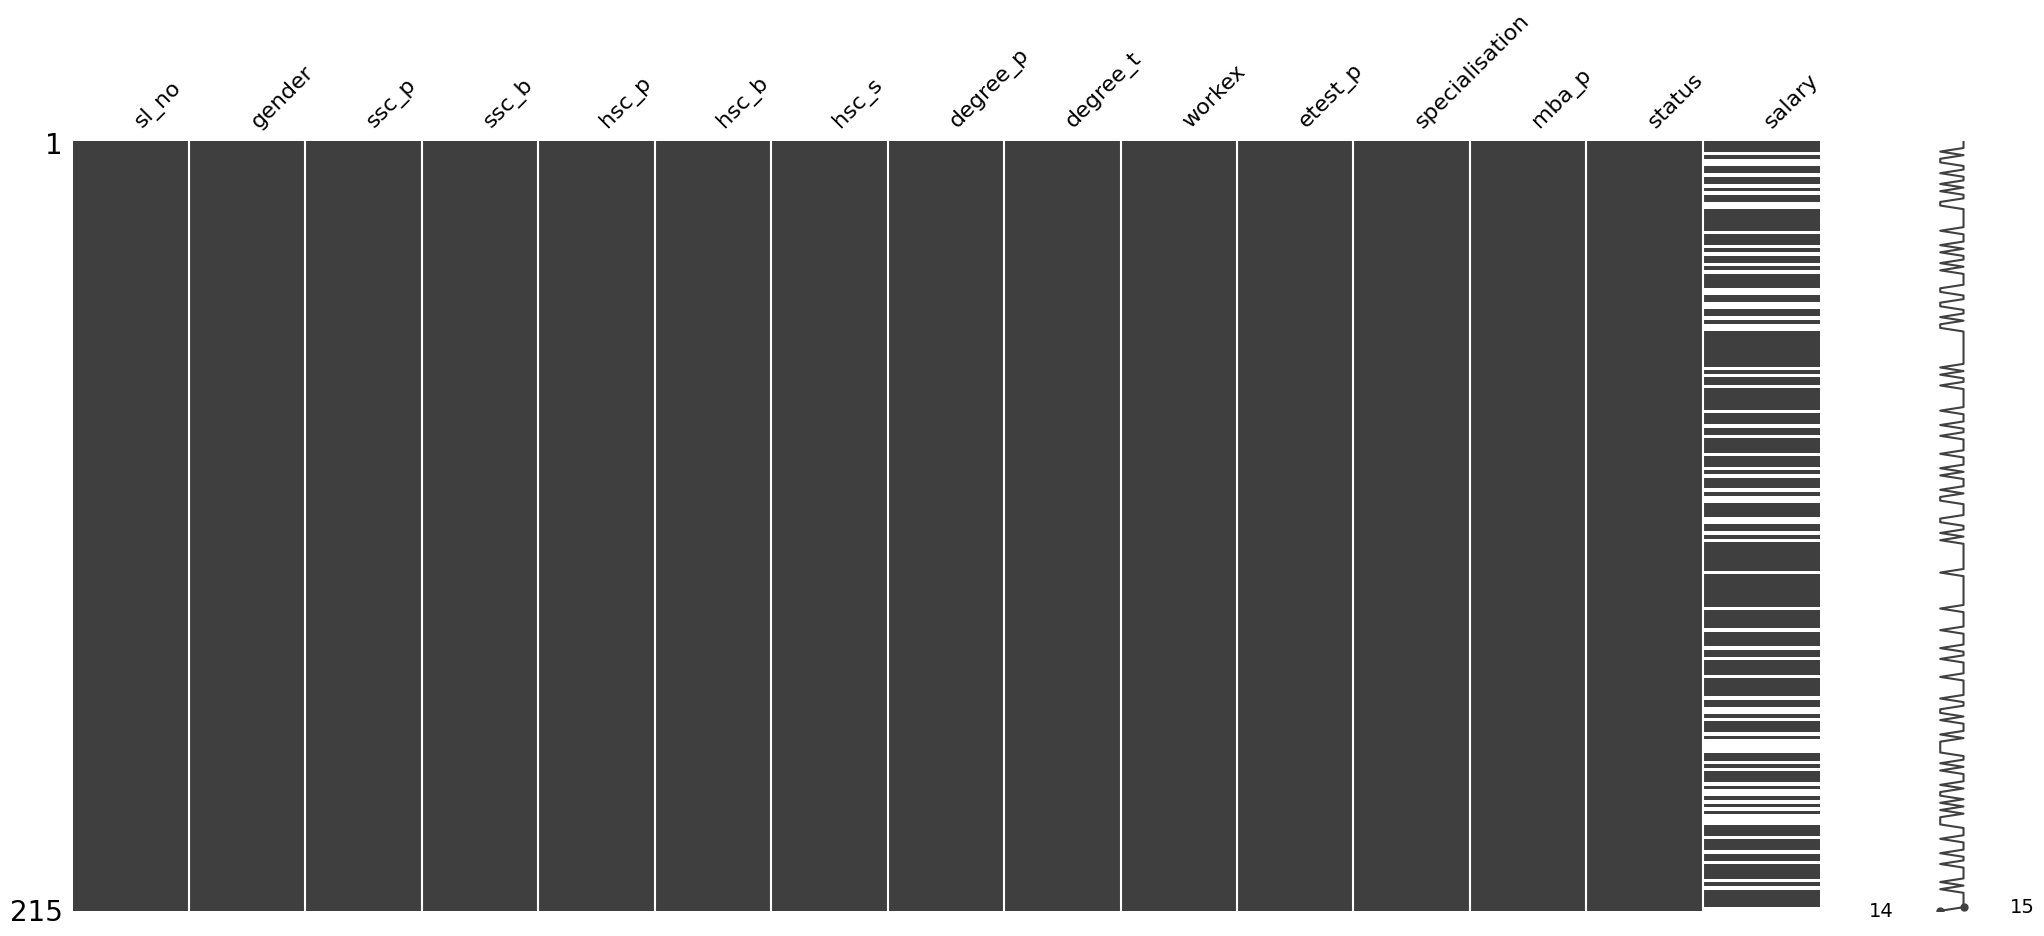

In [17]:
msno.matrix(df.to_pandas())

In [18]:
df.select(pl.all().null_count())

sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,67


Vamos verificar esses dados nulos em relação à nossa variável target

<Axes: xlabel='status', ylabel='salary'>

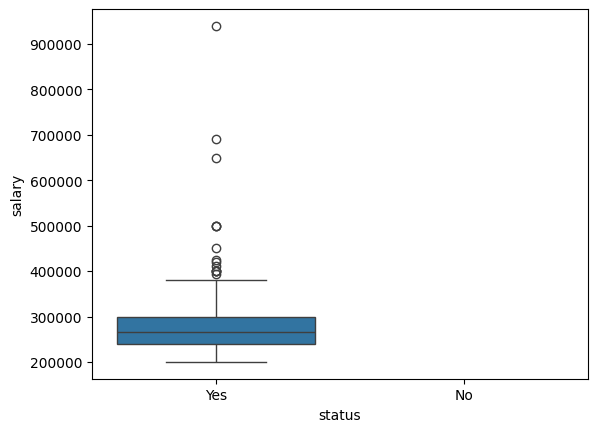

In [19]:
sns.boxplot(data=df, x='status', y='salary')

Podemos perceber que a variável salário é atribuida após a contratação, não se refere a um histórico, e por tanto, não é uma variável que podemos utilizar para prever a contratação.

Vamos analisar outras variáveis

<Axes: xlabel='hsc_p'>

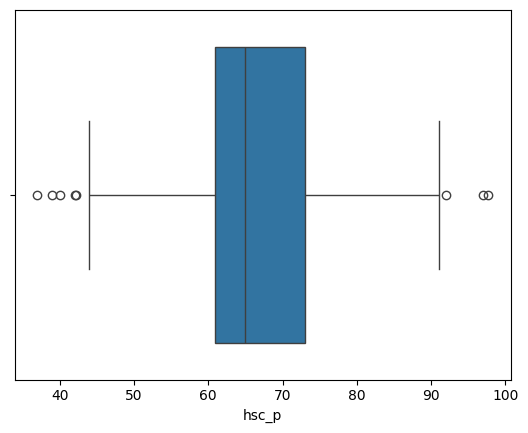

In [20]:
sns.boxplot(data=df, x='hsc_p')

<Axes: xlabel='hsc_p', ylabel='Count'>

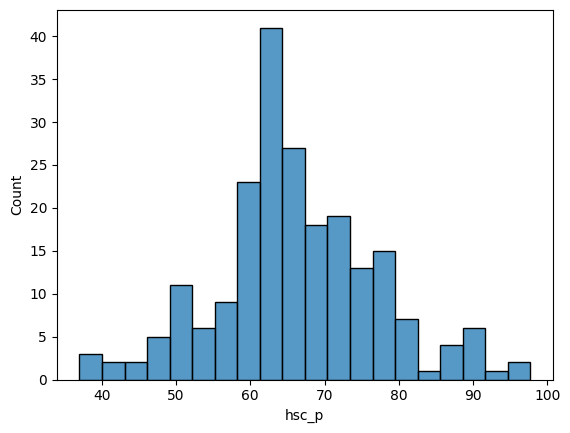

In [21]:
sns.histplot(data=df, x='hsc_p', bins=20)

<Axes: xlabel='degree_p'>

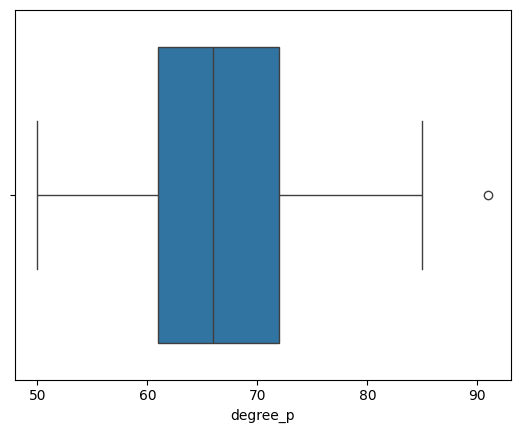

In [22]:
sns.boxplot(data=df, x='degree_p')

<Axes: xlabel='degree_p', ylabel='Count'>

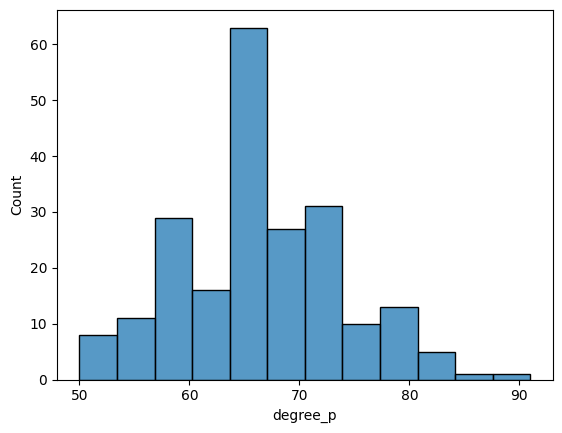

In [23]:
sns.histplot(data=df, x='degree_p')

<Axes: xlabel='etest_p'>

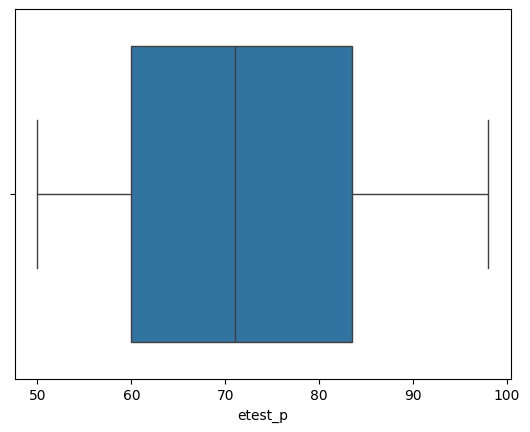

In [24]:
sns.boxplot(data=df, x='etest_p')

<Axes: xlabel='mba_p'>

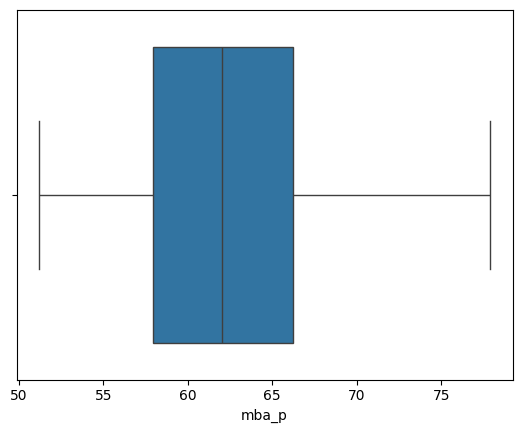

In [25]:
sns.boxplot(data=df, x='mba_p')

<Axes: xlabel='salary'>

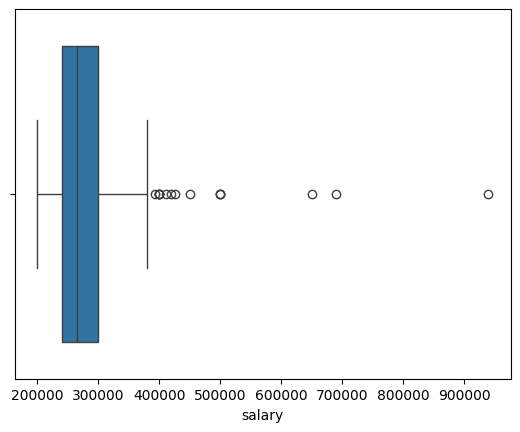

In [35]:
sns.boxplot(data=df, x='salary')

<Axes: xlabel='salary', ylabel='Count'>

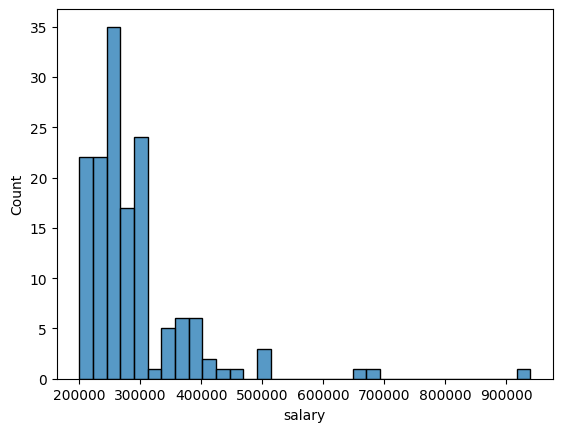

In [37]:
sns.histplot(data=df, x='salary')